# <font color='blue'>Data Science Academy - Deep Learning Frameworks</font>

## Theano - Multilayer Perceptron

Um MLP (Multilayer Perceptron) com uma camada interna às vezes é chamado de arquitetura rasa, em contraste com um MLP com mais camadas internas que às vezes é chamado de arquitetura profunda.

A Multilayer Perceptron (MLP) é uma rede neural semelhante à perceptron, mas com mais de uma camada de neurônios em alimentação direta. Tal tipo de rede é composta por camadas de neurônios ligadas entre si por sinapses com pesos. O aprendizado nesse tipo de rede é geralmente feito através do algoritmo de retro-propagação do erro (Backpropagation).

### Compreendendo o Processo

In [1]:
import numpy as np
import theano.tensor as T
import theano


1- Criar variáveis compartilhadas para pesos e bias. Inicializar pesos com valores aleatórios e bias com zeros

In [2]:
# Parâmetros

# N: número de amostras de treinamento
# D: número de recursos
# H: número de neurônios ocultos
# C: número de classes
N, D, H, C = 10, 1000, 100, 1

# Dados de entrada e saída para treinamento
x= T.vector('x')
y= T.scalar('y', dtype = 'int64')

# Pesos e bias
w1= theano.shared(np.random.randn(D, H), name = 'w1')
w2= theano.shared(np.random.randn(H, C), name = 'w2')
b1= theano.shared(np.zeros((H,)), name = 'b1')
b2= theano.shared(np.zeros((C,)), name = 'b2')

2- Computação de Grafos - Pass Forward

Qual função de ativação não-linear você deve usar em uma rede neural? Dois dos mais comuns são o sigmóide logístico e as funções tanh. Normalmente a preferência é pelas funções não-lineares que são simétricas em torno da origem porque elas tendem a produzir entradas de média zero para a próxima camada (que é uma propriedade desejável). Empiricamente, observamos que o tanh tem melhores propriedades de convergência.

In [3]:
# Função tangente para ativação
y1= T.tanh(T.dot(x,w1)+b1)
y2= T.dot(y1, w2)+b2

# Probabilidade de target = 1
p_1 = 1 / (1 + T.exp(-y2)) 

# Threshold de previsão
prediction = p_1 > 0.5   

# Função de custo com cross_entropy
cent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) 
cost = cent.mean()

3- Computação de Gradientes - Backward Pass

In [4]:
# Cálculo dos gradientes
dw1, dw2, db1, db2 = T.grad(cost, [w1, w2, b1, b2])

4- Define a função de treinamento com updates para os gradientes

In [5]:
# Learning rate
lr= 0.001

# Função de treinamento
train= theano.function(inputs=[x,y],
                       outputs=[cost, prediction],
                       updates= [(w1, w1-lr*dw1), (w2, w2-lr*dw2), (b1, b1-lr*db1), (b2, b2-lr*db2)])

5- Treinamento

In [6]:
# Cria massa de dados
xx = np.array(np.random.randn(N, D), dtype = "float32")
yy = np.random.randint(size = N, low = 0.0, high = C+1)

# Número de iterações
iters=100

# Treinamento
for i in range(iters):
    for j in range(N):
        cost, preds = train(xx[j, :], yy[j])
        if i == iters-1:
            print('Valor observado: ', yy[j], 'Valor previsto: ', preds[0])

Valor observado:  1 Valor previsto:  True
Valor observado:  0 Valor previsto:  False
Valor observado:  0 Valor previsto:  False
Valor observado:  0 Valor previsto:  False
Valor observado:  0 Valor previsto:  False
Valor observado:  1 Valor previsto:  True
Valor observado:  1 Valor previsto:  True
Valor observado:  0 Valor previsto:  False
Valor observado:  0 Valor previsto:  False
Valor observado:  1 Valor previsto:  True


## Criando uma MLP para Classificação

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

### Classe Layer

Vamos definir nosso perceptron multicamada como uma série de "camadas", cada uma aplicada sucessivamente à entrada para produzir a saída da rede. Cada camada é definida como uma classe, que armazena uma matriz de peso e um vetor de bias e inclui uma função para calcular a saída da camada.

Note que se não estivéssemos usando o Theano, poderíamos esperar que o método de saída recebesse um vetor e retornasse a ativação da camada em resposta a essa entrada. No entanto, com Theano, a função de saída é, em vez disso, destinada a ser usada para criar (usando theano.function) uma função que pode receber um vetor e retornar a ativação da camada. Então, se você passar, digamos, um np.ndarray para a função de saída da classe Layer, você receberia um erro. Em vez disso, construiremos uma função para realmente calcular a ativação da camada fora da própria classe.

In [8]:
class Layer(object):
    def __init__(self, W_init, b_init, activation):
        '''
        Uma camada de uma rede neural, calcula s(Wx + b) onde s é uma não linearidade e x é o vetor de entrada.

         : Parâmetros:
             - W_init: np.ndarray, shape = (n_output, n_input)
                 Valores para inicializar a matriz de peso .
             - b_init: np.ndarray, shape = (n_output,)
                 Valores para inicializar o vetor de bias
             - ativação: theano.tensor.elemwise.Elemwise
                 Função de ativação para saída de camada
        '''
        # Recupere a dimensionalidade de entrada e saída com base na inicialização de W
        n_output, n_input = W_init.shape
        
        # Certifique-se que o shape de b é igual a n_output
        assert b_init.shape == (n_output,)
        
        # Todos os parâmetros devem ser variáveis.
        # Eles são usados nesta classe para calcular a saída da camada,
        # Mas são atualizados em outro lugar ao otimizar os parâmetros de rede.
        # Observe que estamos explicitamente exigindo que W_init tenha o tipo theano.config.floatX
        self.W = theano.shared(value = W_init.astype(theano.config.floatX), name = 'W', borrow = True)
        
        # Podemos forçar nosso vetor de bias b a ser um vetor de coluna usando o método de remodelação do numpy.
        # Quando b é um vetor de coluna, podemos passar uma entrada em forma de matriz para a camada
        # E obter uma saída em forma de matriz, graças ao broadcasting
        self.b = theano.shared(value = b_init.reshape(n_output, 1).astype(theano.config.floatX),
                               name = 'b',
                               borrow = True,
                               broadcastable = (False, True))
        self.activation = activation
        
        # Vamos calcular o gradiente do custo da rede em relação aos parâmetros nesta lista.
        self.params = [self.W, self.b]
        
    def output(self, x):
        '''
        Calcule a saída dessa camada dada uma entrada
        
         : Parâmetros:
             - x: theano.tensor.var.TensorVariable
                 Variável simbólica Theano para entrada de camadas

         : Retorna:
             - saída: theano.tensor.var.TensorVariable
                 Mixed, biased e activated x
        '''
        
        # Computação do mix linear
        lin_output = T.dot(self.W, x) + self.b
        
        # A saída é apenas o mix linear se não houver nenhuma função de ativação
        # Caso contrário, aplique a função de ativação
        return (lin_output if self.activation is None else self.activation(lin_output))

### Classe MLP

A maior parte da funcionalidade do nosso MLP está contida na classe Layer acima. A classe MLP (abaixo) é essencialmente apenas um contêiner para uma lista de Layers e seus parâmetros. A função de saída recursivamente computa a saída para cada camada. Finalmente, o squared_error retorna a distância euclidiana ao quadrado entre a saída da rede dada uma entrada e a saída desejada. Esta função destina-se a ser usada como um custo na configuração de minimizar o custo sobre alguns dados de treinamento. Como acima, as funções de erro de saída e quadrado não devem ser usadas para realmente calcular valores. Em vez disso, eles devem ser usados para criar funções que são usadas para calcular valores.

In [9]:
class MLP(object):
    def __init__(self, W_init, b_init, activations):
        '''
        Classe Multilayer Perceptron, computa a composição de uma sequência de camadas

         : Parâmetros:
             - W_init: lista de np.ndarray, len = N
                 Valores para inicializar a matriz de peso em cada camada.
                 O tamanho das camadas será inferido a partir da forma de cada matriz em W_init
             - b_init: lista de np.ndarray, len = N
                 Valores para inicializar o vetor de bias em cada camada.
             - ativações: lista de theano.tensor.elemwise.Elemwise, len = N
                 Função de ativação para saída de camada em cada camada
        '''
        # Certifique-se de que as listas de entrada são todas do mesmo comprimento
        assert len(W_init) == len(b_init) == len(activations)
        
        # Inicializar listas de camadas
        self.layers = []
        
        # Construir as camadas
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))

        # Combinar parâmetros de todas as camadas
        self.params = []
        for layer in self.layers:
            self.params += layer.params
        
    def output(self, x):
        '''
        Calcule a saída do MLP dada uma entrada
        
         : Parâmetros:
             - x: theano.tensor.var.TensorVariable
                 Variável simbólica Theano para entrada da rede

         : Retorna:
             - saída: theano.tensor.var.TensorVariable
                 X passa através do MLP
        '''
        # Recursivamente calcular a saída
        for layer in self.layers:
            x = layer.output(x)
        return x

    def squared_error(self, x, y):
        '''
        Calcule o erro euclidiano quadrado da saída da rede contra a saída "verdadeira" y
        
         : Parâmetros:
             - x: theano.tensor.var.TensorVariable
                 Variável simbólica Theano para entrada da rede
             - y: theano.tensor.var.TensorVariable
                 Variável simbólica Theano para a saída da rede desejada

         : Retorna:
             - Erro: theano.tensor.var.TensorVariable
                 A distância euclidiana ao quadrado entre a saída da rede e y
        '''
        return T.sum((self.output(x) - y)**2)

### Gradiente Descendente e Momentum

Para treinar a rede, minimizaremos o custo (distância euclidiana ao quadrado da saída da rede versus a saída desejada) sobre um conjunto de treinamento usando a descida do gradiente. Ao fazer a descida de gradiente em redes neurais, é muito comum usar momentum, que se mistura na atualização anterior para a atualização atual. Isso tende a fazer a rede convergir mais rapidamente em uma boa solução e pode ajudar a evitar mínimos locais na função de custo. Com a descida de gradiente tradicional, garantimos diminuir o custo em cada iteração. Quando usamos o momentum, perdemos essa garantia, mas isso geralmente é visto como um pequeno preço a pagar pela melhoria que geralmente conseguimos com o momentum.

Em Theano, armazenamos a atualização de parâmetro anterior como uma variável compartilhada para que seu valor seja preservado em iterações. Então, durante a atualização de gradiente, não apenas atualizamos os parâmetros, mas também atualizamos a variável compartilhada de atualização do parâmetro anterior.

Utilizaremos o método momentum, para acelerar a convergência da rede e conferir estabilidade. Nesta técnica, a atualização dos pesos é uma ponderação entre o passo atual e os calculados anteriormente. Consiste em aplicar uma constante µ sobre a mudança no vetor pesos da última iteração, somando-se a esta a correção de direção da iteração corrente. Se a última mudança de pesos foi em uma direção particular, o termo momentum faz com que a próxima mudança de peso seja mais ou menos na mesma direção que a anterior. Dependendo da situação este pequeno desvio pode ser suficiente para evitar que a rede caia em um mínimo local.

In [10]:
def gradient_updates_momentum(cost, params, learning_rate, momentum):
    '''
    Calcular atualizações para a descida do gradiente com momentum
    
     : Parâmetros:
         - custo: theano.tensor.var.TensorVariable
             A função de custo Theano para minimizar
         - params: lista de theano.tensor.var.TensorVariable
             Parâmetros para calcular gradiente contra
         - taxa de aprendizagem: float
             Taxa de aprendizado de descida de gradiente
         - momentum: float
             Momentum parâmetro, deve ser pelo menos 0 (descida padrão gradiente) e menos de 1
   
     : Retorna:
         Atualizações: list
             Lista de atualizações, uma para cada parâmetro
    '''
    # Certifique-se de que o momento é um valor válido
    assert momentum < 1 and momentum >= 0
    
    # Lista de etapas de atualização para cada parâmetro
    updates = []
    
    # Apenas a descida do gradiente sobre o custo
    for param in params:
        # Para cada parâmetro, criaremos uma variável compartilhada previous_step.
        # Essa variável acompanhará a etapa de atualização do parâmetro entre iterações.
        # Inicializamos com 0
        previous_step = theano.shared(param.get_value()*0., broadcastable=param.broadcastable)
        
        # Cada parâmetro é atualizado dando um passo na direção do gradiente.
        # No entanto, também "misturamos" o passo anterior de acordo com o valor de momentum dado.
        # Note que não precisamos derivar backpropagation para calcular atualizações - basta usar T.grad!
        step = momentum*previous_step - learning_rate*T.grad(cost, param)
        
        # Adicionar uma atualização para armazenar o valor da etapa anterior
        updates.append((previous_step, step))
        
        # Adicione uma atualização para aplicar o passo de descida de gradiente ao parâmetro propriamente dito
        updates.append((param, param + step))
    return updates

### Treinamento

Definindo a massa de dados

/home/rmacedo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  


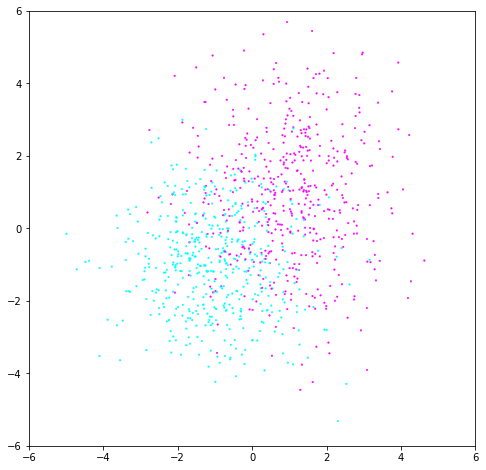

In [11]:
# Seed
np.random.seed(0)

# Número de pontos
N = 1000

# Labels para cada cluster
y = np.random.random_integers(0, 1, N)

# Média de cada cluster
means = np.array([[-1, 1], [-1, 1]])

# Covariância (em direção X e Y) de cada cluster
covariances = np.random.random_sample((2, 2)) + 1

# As dimensões de cada ponto
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]]).astype(theano.config.floatX)

# Converta para targets (y), como floatX
y = y.astype(theano.config.floatX)

# Plot 
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8, 8))
plt.scatter(X[0, :], X[1, :], c=y, lw=.3, s=3, cmap=plt.cm.cool)
plt.axis([-6, 6, -6, 6])
plt.show()

 Definindo as camadas 

In [12]:
# Primeiro, defina o tamanho de cada camada (e o número de camadas)
# O tamanho da camada de entrada é a dimensionalidade dos dados de treinamento (2)
# O tamanho da saída é apenas 1-d: class label - 0 ou 1
# Finalmente, deixe as camadas ocultas serem duas vezes o tamanho da entrada.
# Se quisermos mais camadas, podemos adicionar outro tamanho de camada a esta lista.
layer_sizes = [X.shape[0], X.shape[0]*2, 1]

# Definir valores de parâmetros iniciais
W_init = []
b_init = []
activations = []

for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    # Obter a inicialização correta é muito importante.
    # No entanto, aqui podemos apenas usar a seguinte inicialização com sucesso:
    # Normalmente distribuir pesos iniciais de forma aleatória
    W_init.append(np.random.randn(n_output, n_input))
    
    # Definir bias iniciais para 1
    b_init.append(np.ones(n_output))
    
    # Usaremos a ativação sigmóide para todas as camadas
    activations.append(T.nnet.sigmoid)

# Criar uma instância da classe MLP
mlp = MLP(W_init, b_init, activations)

# Criar variáveis Theano para a entrada MLP
mlp_input = T.matrix('mlp_input')

# ... e a saída desejada
mlp_target = T.vector('mlp_target')

# Taxa de aprendizado e valores de hiperparâmetro de momentum
# Estes valores podem fazer uma grande diferença no treinamento da rede
# Se a rede (rapidamente) converge em um mínimo local bom.
learning_rate = 0.01
momentum = 0.9

# Criar uma função para calcular o custo da rede dada uma entrada
cost = mlp.squared_error(mlp_input, mlp_target)

# Criar uma função theano para treinar a rede
train = theano.function([mlp_input, mlp_target], cost,
                        updates=gradient_updates_momentum(cost, mlp.params, learning_rate, momentum))

# Crie uma função de theano para computar a saída da MLP dada alguma entrada
mlp_output = theano.function([mlp_input], mlp.output(mlp_input))

Treinando o modelo

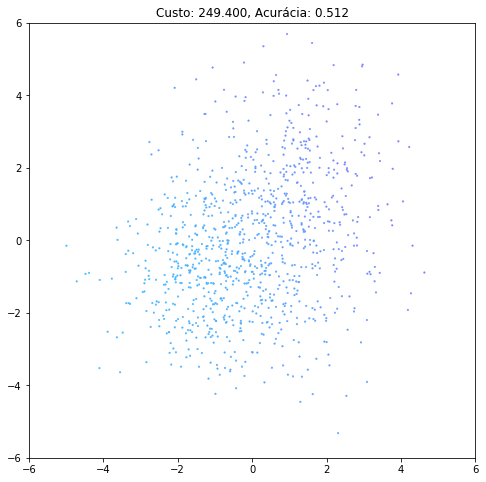

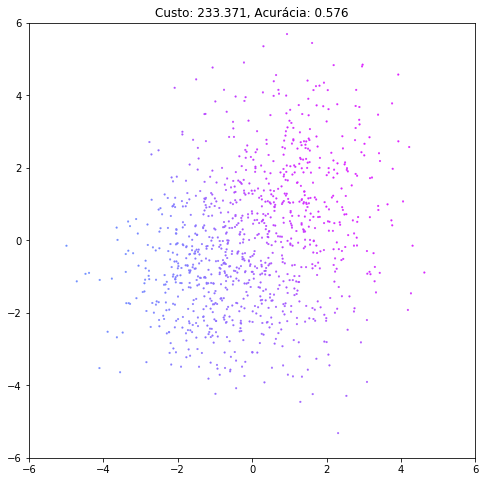

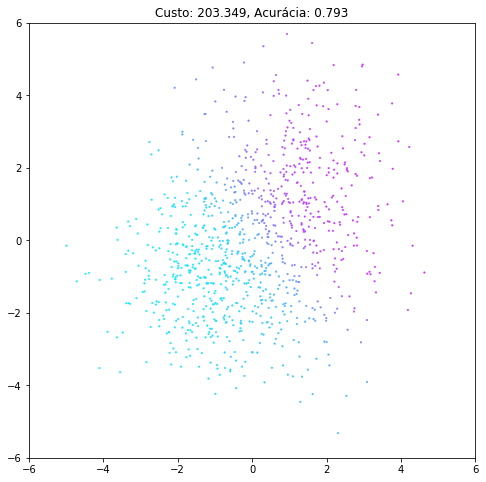

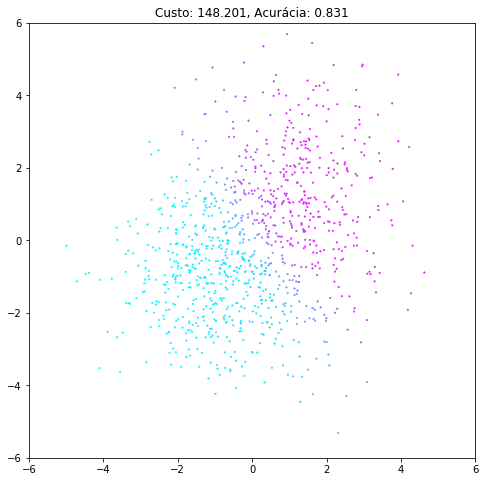

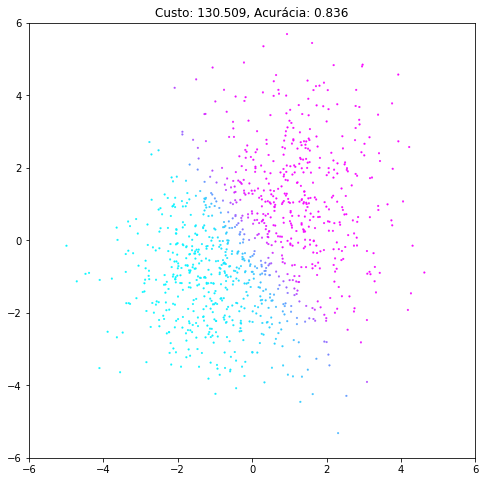

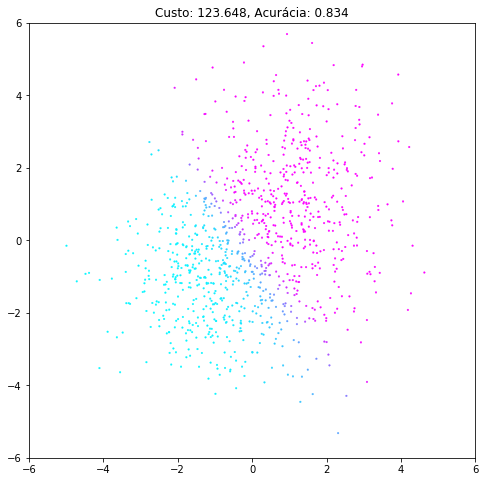

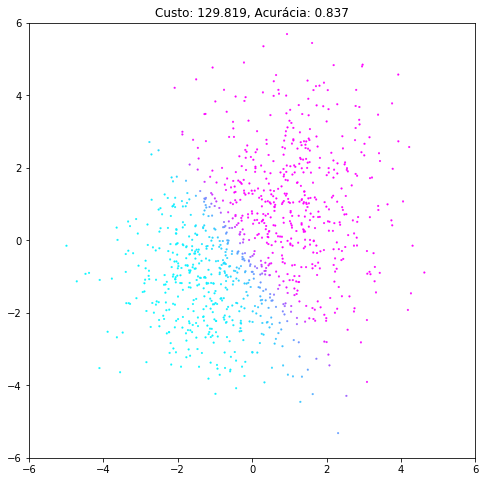

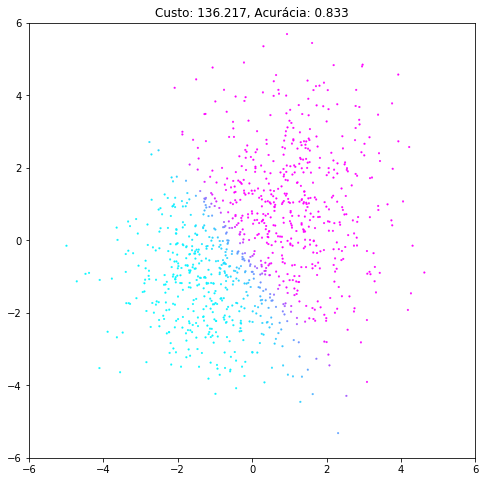

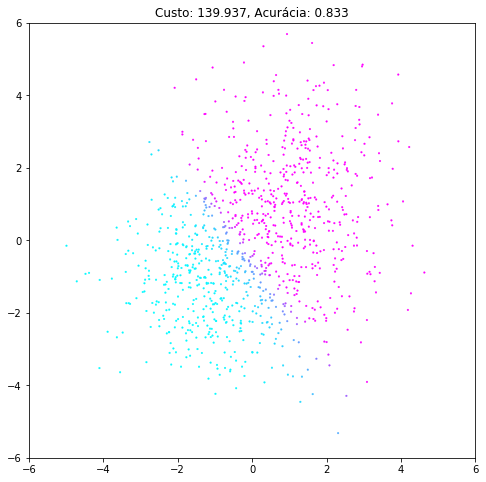

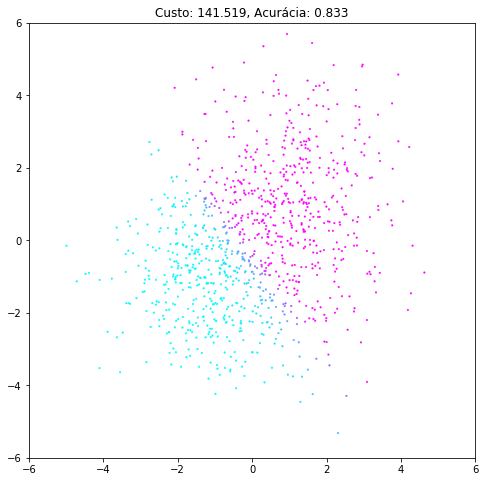

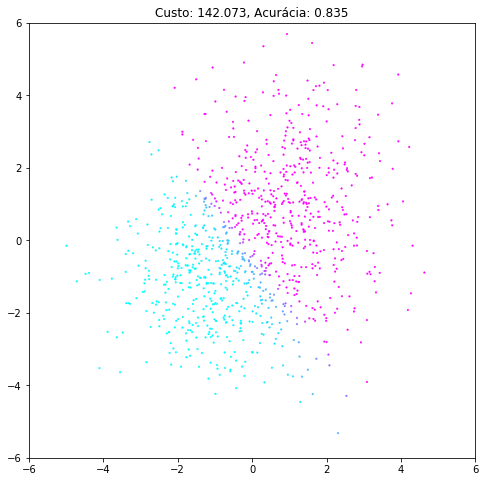

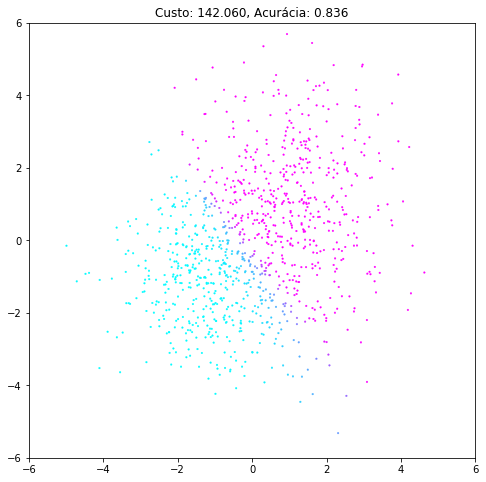

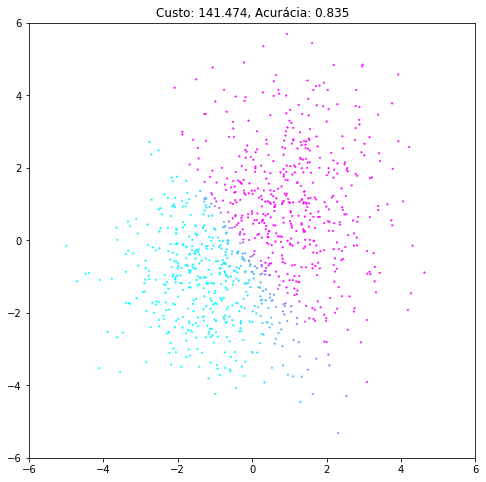

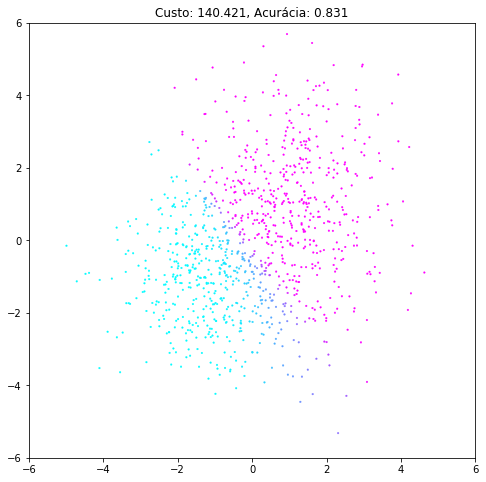

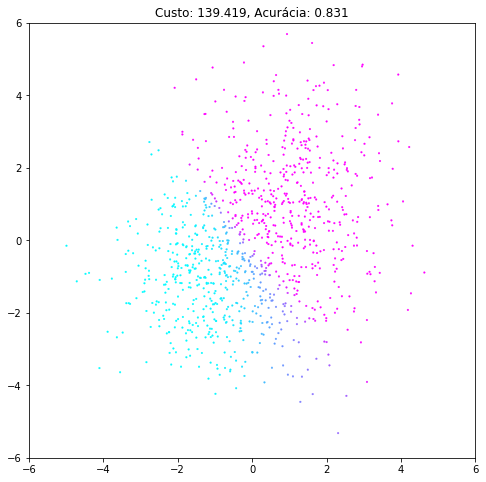

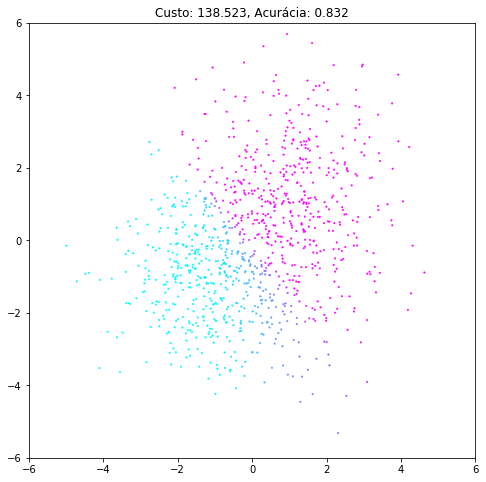

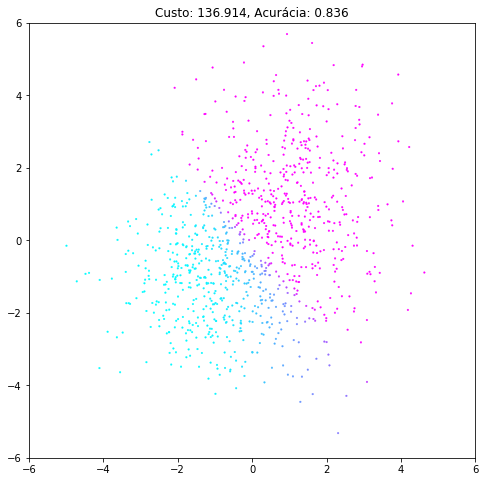

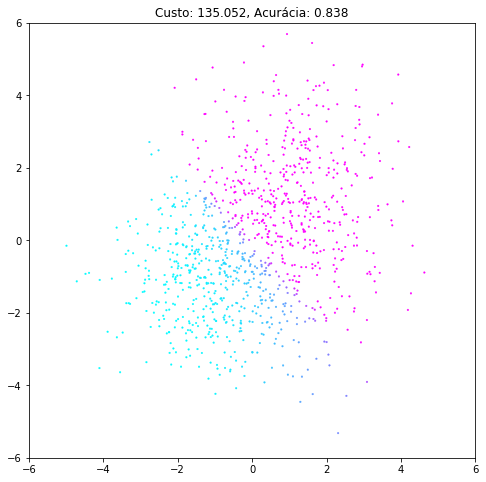

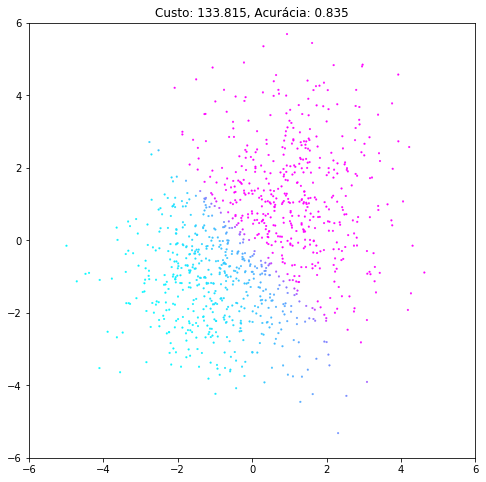

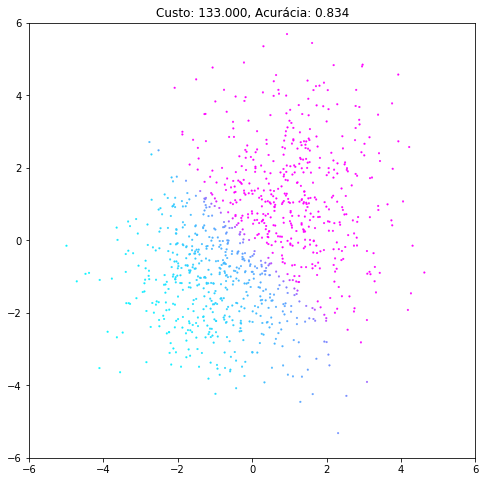

In [13]:
# Acompanhar o número de iterações de treinamento realizadas
iteration = 0

# Nós só treinaremos a rede com 20 iterações.
# Uma técnica mais comum é usar um conjunto de validação.
# Quando o erro de validação começa a aumentar, a rede é overfitting,
# Assim paramos de treinar a rede. Isso é chamado de "parar cedo" (early-stop), o que não vamos fazer aqui.
max_iteration = 20

# Treine a rede usando todo o conjunto de treinamento.
while iteration < max_iteration:
    # Com grandes conjuntos de dados, é muito mais comum usar a descida de gradiente estocástica ou de mini-batch
    # Onde somente um subconjunto (ou um único ponto) do conjunto de treinamento é usado em cada iteração.
    # Isso também pode ajudar a rede a evitar mínimos locais.
    current_cost  = train(X, y)
    
    # Obter a saída de rede atual para todos os pontos no conjunto de treinamento
    current_output  = mlp_output(X)
    
    # Podemos calcular a precisão através do limiar da saída
    # E computando a proporção de pontos cuja classe corresponde à classe de saída desejada.
    accuracy  = np.mean((current_output > .5) == y)
    
    
    # Plot da saída de rede após esta iteração
    plt.figure(figsize=(8, 8))
    plt.scatter(X[0, :], X[1, :], c=current_output.flatten(),
                lw=.3, s=3, cmap=plt.cm.cool, vmin=0, vmax=1)
    plt.axis([-6, 6, -6, 6])
    plt.title('Custo: {:.3f}, Acurácia: {:.3f}'.format(float(current_cost), accuracy))
    plt.show()
    iteration += 1

## Fim